# World Wide Products Inc.
 - EECS 731 Project 5
 - Author: Ashwin Rathore

## Problem Statement
### Determine Demand for a particular product
1. Set up a data science project structure in a new git repository in your GitHub account
2. Download the product demand data set from
https://www.kaggle.com/felixzhao/productdemandforecasting
3. Load the data set into panda data frames
4. Formulate one or two ideas on how feature engineering would help the data set to establish additional value using exploratory data analysis
5. Build one or more forecasting models to determine the demand for a particular product using the other columns as features
6. Document your process and results
7. Commit your notebook, source code, visualizations and other supporting files to the git repository in GitHub

## Goal
Our goal is to predict the demand of a product for the upcoming month by using the data of the deman of the same product in previous months.

#### Step 1: Imort data from Demand.csv into pandas dataframe

In [371]:
import pandas as pd
data = pd.read_csv(r'C:\Stuff\KU Study\EECS 731 Intro to Data Science\Project 5\data\external\Historical Product Demand.csv')

Let's check the top rows of the dataset.

In [372]:
data.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,27-07-12,100
1,Product_0979,Whse_J,Category_028,19-01-12,500
2,Product_0979,Whse_J,Category_028,03-02-12,500
3,Product_0979,Whse_J,Category_028,09-02-12,500
4,Product_0979,Whse_J,Category_028,02-03-12,500


#### Step 2: Data Analysis and Feature Engineering

Check the number of samples in the dataset

In [373]:
data.shape

(1048575, 5)

We have over 1 million samples in this dataset. 
Our goal is to predict the demand of a product so Warehouse and Product_Category are not going to help us in achieving the same.
Let's drop both the columns and look at the dataset.

In [374]:
data = data.drop(["Warehouse", "Product_Category"],axis='columns')
data.head()

,Product_Code,Date,Order_Demand
0,Product_0993,27-07-12,100
1,Product_0979,19-01-12,500
2,Product_0979,03-02-12,500
3,Product_0979,09-02-12,500
4,Product_0979,02-03-12,500


Now we check the missing data in the dataset

In [375]:
data.isnull().sum()

Product_Code        0
Date            11239
Order_Demand        0
dtype: int64

We have 11239 missing values in the Date feature.
Date is an important feature in determing the demand becuase it is a Time feature and we are going to predict the demand for a time in future.
So, we will drop the all samples with missing values found above.

In [376]:
data.dropna(subset = ["Date"], inplace=True)
data.isnull().sum()

Product_Code    0
Date            0
Order_Demand    0
dtype: int64

Let's see what else we can do with the data

In [377]:
data.head()

,Product_Code,Date,Order_Demand
0,Product_0993,27-07-12,100
1,Product_0979,19-01-12,500
2,Product_0979,03-02-12,500
3,Product_0979,09-02-12,500
4,Product_0979,02-03-12,500


In the Date feature, the format of date is dd-mm-yy which is not acceptable in the Forecasting model so we need to convert it into yyyy-mm-dd.

First we will split the date on the basis of "-" in to three columns.

In [378]:
Date=data.Date.str.split("-",expand=True) 
Date.head(3)

,0,1,2
0,27,07,12
1,19,01,12
2,03,02,12


Now we can see that Date is a new dataframe with columns as dd, mm, and yy.
Now we convert the Year column in to strin and add "20" as prefix so we can convert yy to yyyy. Ex- 16 will be 2016

In [379]:
Date[2] = '20' + Date[2].astype(str)
Date.head(3)

,0,1,2
0,27,07,2012
1,19,01,2012
2,03,02,2012


Now we will combine year and month columns in the format yyyy-mm by concatenating them.

In [380]:
Date['Combined'] = Date[2].str.cat(Date[1],sep="-")
Date.head(3)

,0,1,2,Combined
0,27,07,2012,2012-07
1,19,01,2012,2012-01
2,03,02,2012,2012-02


Now we will concatenate the "-01" at the end of every combined value which gives us yyyy-mm-dd format of date. The reason behind adding the 01 as the day is that we will be predicting the demand of product for the upcoming month based on the previous months and have different dates of the same month doesn't make any difference.

In [381]:
Date['Combined'] = Date['Combined'].astype(str)+"-01"

Now we replace the Date feature's values in our original dataframe with the new date format

In [382]:
data['Date'] =  Date['Combined']
data.dtypes

Product_Code    object
Date            object
Order_Demand     int64
dtype: object

The Date feature has a datatype of object as we can see above and we need datetime64 to feed the data in to the models so we change it.

In [383]:
data['Date']=data['Date'].astype('datetime64[ns]')
data.dtypes

Product_Code            object
Date            datetime64[ns]
Order_Demand             int64
dtype: object

Let's look at the data again and see what else we can do.

In [384]:
data.head(5)

,Product_Code,Date,Order_Demand
0,Product_0993,2012-07-01,100
1,Product_0979,2012-01-01,500
2,Product_0979,2012-02-01,500
3,Product_0979,2012-02-01,500
4,Product_0979,2012-03-01,500


We have multiple entries of a products demand in a month in the dataframe and we are going calculate the average demand of a product on per day for a month so that we can predict the same for the upcoming months.

In [385]:
df = data.groupby(['Product_Code', 'Date'])['Order_Demand'].mean().reset_index()
df.head()

,Product_Code,Date,Order_Demand
0,Product_0001,2011-12-01,150.000000
1,Product_0001,2012-01-01,646.666667
2,Product_0001,2012-02-01,1000.000000
3,Product_0001,2012-03-01,1084.615385
4,Product_0001,2012-04-01,471.428571


    We save this processed data in to a file so we can use it later also.

In [386]:
df.to_csv(r"C:\Stuff\KU Study\EECS 731 Intro to Data Science\Project 5\data\processed\Processed_data.csv",index=False) 

Now, to predict the demand for a particular product, we need to have the demand of that particular product for the whole time in a dataframe. We can use the above data to predict the demand for any of the products or the all the products together.


We will transform the data frame to get Date as index, Product_Code as columns and Order_Demand as the values in for the particular product's demand.

In [387]:
df2=df.pivot(index='Date', columns='Product_Code', values='Order_Demand')

In [388]:
Let's look at the data

SyntaxError: EOL while scanning string literal (<ipython-input-388-e67979e158d4>, line 1)

In [ ]:
df2.head()

We have 2160 columns in the datafram and each of them represents a different product.
Let's select a product by seeing which one has lesser nuber of missing values. THe missing values are generated for the products because the prducts doesn't have the data of demand for every month and some data might be missing for each of the products.

In [389]:
df2.isnull().sum()

Product_Code
Product_0001     7
Product_0002     7
Product_0003     8
Product_0004    11
Product_0005    34
                ..
Product_2168     8
Product_2169     7
Product_2170    11
Product_2171     8
Product_2172    38
Length: 2160, dtype: int64

Let's take the data of Product_0001 to fit the model and make predictions of it's demand as it has only 7 missing values.

In [390]:
df3 = df2['Product_0001'].copy()
df3

Date
2011-01-01           NaN
2011-05-01           NaN
2011-06-01           NaN
2011-09-01           NaN
2011-10-01           NaN
                 ...    
2016-09-01    471.428571
2016-10-01    300.000000
2016-11-01    300.000000
2016-12-01    283.333333
2017-01-01           NaN
Name: Product_0001, Length: 68, dtype: float64

Now we drop the missing values of data for the Product_0001 and see how many samples do we have to feed the model

In [391]:
df3=df3.dropna()
df3

Date
2011-12-01     150.000000
2012-01-01     646.666667
2012-02-01    1000.000000
2012-03-01    1084.615385
2012-04-01     471.428571
                 ...     
2016-08-01    1590.909091
2016-09-01     471.428571
2016-10-01     300.000000
2016-11-01     300.000000
2016-12-01     283.333333
Name: Product_0001, Length: 61, dtype: float64

### Step 3: Deterning Demand using Forecasting model 
First we divide the data in to training and test data. As we can see we have 60 samples above for Product_0001, we keep 48 samples in training data and 12 samples in test data.

In [392]:
train, test = monthly_avg_sales[0:-12], monthly_avg_sales[-12:]
print(train.size, test.size)

48 12


#### We are going to use ARIMA(autoregressive integrated moving average) Forecasting model:
Now, We will use a walk-forward validation method to evaluate model performance. This means that each time step in the test dataset will be enumerated, a model constructed on history data, and the forecast compared to the expected value. The observation will then be added to the training dataset and the process repeated.Walk-forward validation is a realistic way to evaluate time series forecast models as one would expect models to be updated as new observations are made available. An ARIMA(4,1,0) forecast model will be used as the baseline to explore the additional parameters of the model.

In [405]:
history = [x for x in train]
history
predictions=[]

In [406]:
from statsmodels.tsa.arima_model import ARIMA
for t in range(len(test)):
	# fit model
	model = ARIMA(history, order=(4,1,0))
	model_fit = model.fit()
	# one step forecast
	yhat = model_fit.forecast()[0]
	# store forecast and ob
	predictions.append(yhat[0])
	history.append(test[t])

Finally, forecasts will be evaluated using root mean squared error, or RMSE.

In [407]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 405.751


We have got an RMSE value of 405.71 by evaluating the predictions made using ARIMA forecasting model.
Now we convert the predictions made by ARIMA model in to dataframe so we can plot it side by side with the actual demand in the test data.

In [408]:
prediction=pd.DataFrame(test)
prediction['Order_Demand']=predictions

Now we plot the predicted demand of the Product_0001 and the actual demand of the product in that particular month in 2016

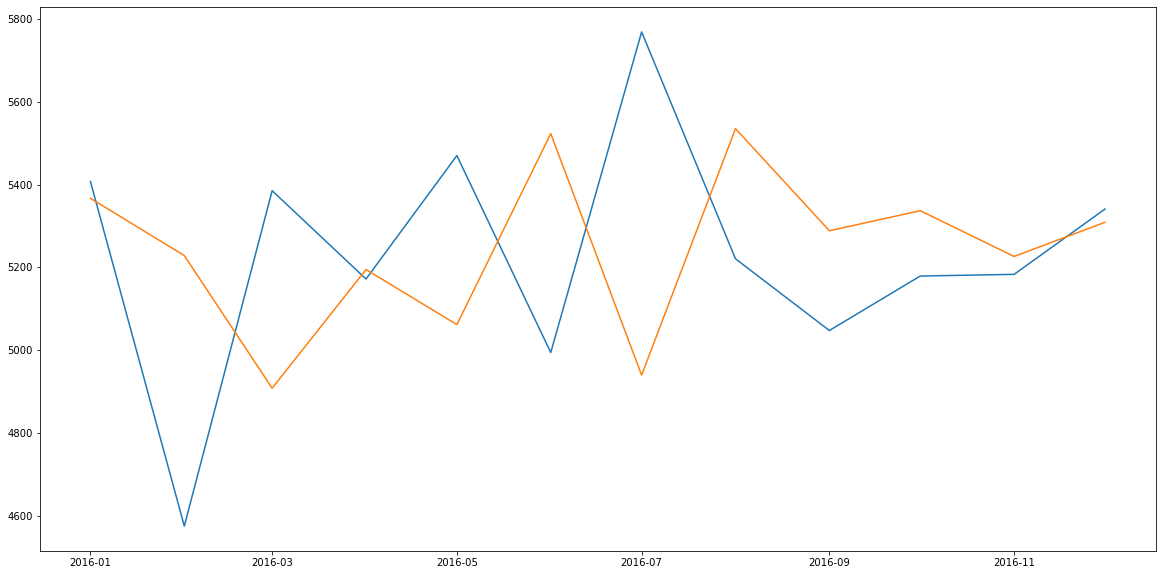

In [409]:
plt.plot(pd.DataFrame(test))
plt.plot(prediction)
plt.show()

## Observation:
- We have seen ARIMA Forecasting models performance.
- We can get better accuracy by tuning parameters  This is clear indication of over-fitting as we have left all parameters to baseline values.
